# Calculating catches from gridded DBPM outputs
**Author**: Denisse Fierro Arcos  
**Date**: 2025-02-06  

In this notebook, we will calculate catches from gridded DBPM outputs.

## Loading relevant libraries

In [1]:
import os
os.chdir('/g/data/vf71/la6889/dbpm_southern_ocean/scripts/')
import useful_functions as uf
from glob import glob
import xarray as xr
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client

## Start a cluster for parallelisation

In [2]:
client = Client(threads_per_worker = 1, connection_limit = 0)

## Defining basic variables to run gridded DBPM

In [2]:
#Name of region and model resolution
region = 'fao-48'
model_res = '025deg'

#Defining input and output folders
base_folder = '/g/data/vf71/la6889/dbpm_inputs/weddell'
gridded_inputs = os.path.join(base_folder, 'gridded_params', model_res)
gridded_outputs = os.path.join(base_folder, 'run_fishing', model_res)
outputs_folder = os.path.join(base_folder, 'gridded_dbpm_outputs', model_res)

#Ensure outputs folder exists
os.makedirs(outputs_folder, exist_ok = True)

## Loading gridded parameters and gridded inputs

In [3]:
#Gridded DBPM parameters
gridded_params = json.load(open(
    os.path.join(gridded_inputs, f'dbpm_gridded_size_params_{region}_python.json')))

#Mortality from fishing (predators and detritivores)
fish_mort_det = xr.open_zarr(glob(
    os.path.join(gridded_inputs, 'fish-mort-det*'))[0])['fish_mort_det']
fish_mort_pred = xr.open_zarr(glob(
    os.path.join(gridded_inputs, 'fish-mort-pred*'))[0])['fish_mort_pred']

#Effort - Only initialisation time step
effort_init = xr.open_zarr(glob(
    os.path.join(gridded_inputs, 'effort_spinup*'))[0])['effort'].isel(time = 0)

#Size class bins
log10_size_bins_mat = xr.open_zarr('outputs/log10_size_bins_matrix.zarr/')['size_bins']
size_bin_vals = 10**log10_size_bins_mat

#Area - to be used for masking land areas
area = xr.open_zarr(glob(os.path.join(base_folder, 'gridded', model_res, 
                                      '*areacello*'))[0])['cellareao']

## Loading gridded DBPM outputs 

In [4]:
predators = xr.open_mfdataset(glob(
    os.path.join(gridded_outputs, 'predators*')))['predators']

detritivores = xr.open_mfdataset(glob(
    os.path.join(gridded_outputs, 'detritivores*')))['detritivores']

effort = xr.open_mfdataset(glob(os.path.join(gridded_outputs, 'effort*')))['effort']

#Add initial effort values
effort = xr.concat([effort_init, effort], dim = 'time')

## Calculate fishing mortality 

In [38]:
fishing_mort_pred = fish_mort_pred*effort
fishing_mort_det = fish_mort_det*effort 

## Calculates catches per time step and size class
`fishing_mort_pred` and `fishing_mort_det` are set to zero outside the sizes for each class, so there is no need to apply a mask here.

In [39]:
catch_pred = fishing_mort_pred*predators*size_bin_vals
catch_det = fishing_mort_det*detritivores*size_bin_vals

## Calculate pelagic predator and benthic detritivore catches from DBPM outputs

In [40]:
# We calculate total catches for detritivores and predators 
# That is we add catches across all fished size classes
tot_catch_pred = (catch_pred*gridded_params['log_size_increase']).sum('size_class')
tot_catch_det = (catch_det*gridded_params['log_size_increase']).sum('size_class')

### Calculate mean decadal catches

In [9]:
#Predator catches
mean_catch_pred_dec = uf.decadal_catches(
    tot_catch_pred, area, name = 'catch_predators',
    attrs = {'units': 'g*decade-1*m-2', 
             'long_name': 'mean predators biomass caught per decade'})

#Detritivore catches
mean_catch_det_dec = uf.decadal_catches(
    tot_catch_det, area, name = 'catch_detritivores',
    attrs = {'units': 'g*decade-1*m-2', 
             'long_name': 'mean detritivores biomass caught per decade'})

#Total catches
sum_catch_dec = mean_catch_pred_dec + mean_catch_det_dec
sum_catch_dec.name = 'catch_total'
sum_catch_dec = sum_catch_dec.assign_attrs({'units': 'g*decade-1*m-2', 
                                            'long_name': 'mean biomass caught per decade'})

#Store catches in a single dataset
mean_catch_dec = xr.Dataset(data_vars = {'catch_det': mean_catch_det_dec,
                                         'catch_pred': mean_catch_pred_dec,
                                         'catch_sum': sum_catch_dec})

### Saving catches

In [10]:
#Get start and end decade
s_dec = str(mean_catch_dec.decade.values.min())
e_dec = str(mean_catch_dec.decade.values.max())

#Create filename to save results
fout = os.path.join(outputs_folder,
                    f'mean_decadal_catches_{model_res}_{region}_{s_dec}_{e_dec}.nc')

#Saving dataset
mean_catch_dec.to_netcdf(fout)

### *Optional*: Load catches if previously processed

In [21]:
#Name of region and model resolution
region = 'fao-58'
model_res = '1deg'

#Defining input and output folders
base_folder = '/g/data/vf71/la6889/dbpm_inputs/east_antarctica/'
gridded_inputs = os.path.join(base_folder, 'gridded_params', model_res)
gridded_outputs = os.path.join(base_folder, 'run_fishing', model_res)
outputs_folder = os.path.join(base_folder, 'gridded_dbpm_outputs', model_res)

In [22]:
mean_catch_dec = xr.open_dataset(
    glob(os.path.join(outputs_folder,
                      f'mean_decadal_catches_{model_res}_{region}_*.nc'))[0])

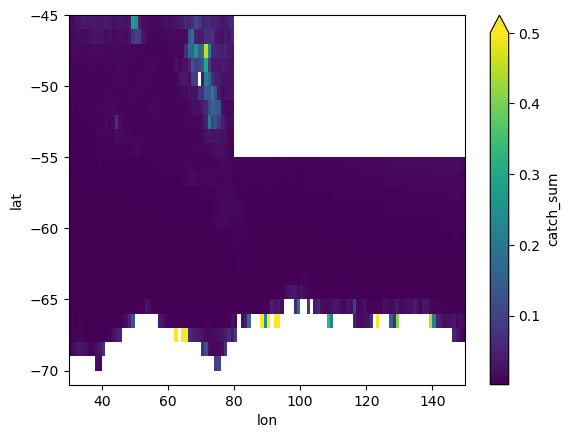

In [27]:
# tot = mean_catch_dec['catch_sum'].sel(decade = slice(2000, None)).mean('decade')
tot.where(tot > 0).plot(vmax = .5)

## Calculating weighted mean for yearly catches from DBPM outputs (time series)
To make results comparable to outputs from the non-spatial DBPM, we will calculate the weighted mean for catches per year.

In [41]:
# We can now calculate the total catch
total_catch = tot_catch_det+tot_catch_pred
total_catch.name = 'mean_catch'

# Creating weights from grid cell area 
weights = area.fillna(0)

In [42]:
# Finally we calculate the mean yearly catch
catch_weighted_mean = []

#We will group data by year first and then calculate the weighted mean
for yr, d in total_catch.groupby('time.year'):
    d_weighted = d.weighted(weights)
    dw_mean = d_weighted.mean(('time', 'lat', 'lon')).expand_dims({'year': [yr]})
    catch_weighted_mean.append(dw_mean)

catch_weighted_mean = xr.concat(catch_weighted_mean, dim = 'year')

In [43]:
# Transforming to data frame
catch_weighted_mean = catch_weighted_mean.to_pandas().reset_index()
# Adding units 
catch_weighted_mean['units'] = 'g*year-1*m-2'

### Saving mean catches

In [44]:
# Getting min and max year from data
min_yr = str(catch_weighted_mean.year.min())
max_yr = str(catch_weighted_mean.year.max())

# Creating name for file 
out_name = f'mean_year_catch_dbpm_{model_res}_{region}_{min_yr}-{max_yr}.parquet'

# Saving in output folder
catch_weighted_mean.to_parquet(os.path.join(outputs_folder, out_name))